In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append("..\\..\\ribasim\\python\\ribasim")
import ribasim

In [2]:
profile = pd.DataFrame(
    data={
        "node_id": [1, 1, 3, 3, 6, 6, 9, 9],
        "area": [0.01, 1000.0] * 4,
        "level": [0.0, 1.0] * 4,
    }
)

# Convert steady forcing to m/s
# 2 mm/d precipitation, 1 mm/d evaporation
seconds_in_day = 24 * 3600
precipitation = 0.002 / seconds_in_day
evaporation = 0.001 / seconds_in_day

static = pd.DataFrame(
    data={
        "node_id": [0],
        "drainage": [0.0],
        "potential_evaporation": [evaporation],
        "infiltration": [0.0],
        "precipitation": [precipitation],
        "urban_runoff": [0.0],
    }
)
static = static.iloc[[0, 0, 0, 0]]
static["node_id"] = [1, 3, 6, 9]

basin = ribasim.Basin(profile=profile, static=static)
basin

<ribasim.Basin>
   profile: DataFrame(rows=8) (remarks, area, node_id, level)
   static: DataFrame(rows=4)
       (remarks, precipitation, infiltration,
       urban_runoff, node_id, potential_evaporation,
       drainage)
   time: None
   state: None

In [3]:
linear_resistance = ribasim.LinearResistance(
    static=pd.DataFrame(
        data={"node_id": [10, 12], "resistance": [5e3, (3600.0 * 24) / 100.0]}
    )
)
linear_resistance

<ribasim.LinearResistance>
   static: DataFrame(rows=2)
       (remarks, active, node_id, resistance,
       control_state)

In [4]:
manning_resistance = ribasim.ManningResistance(
    static=pd.DataFrame(
        data={
            "node_id": [2],
            "length": [900.0],
            "manning_n": [0.04],
            "profile_width": [6.0],
            "profile_slope": [3.0],
        }
    )
)
manning_resistance

<ribasim.ManningResistance>
   static: DataFrame(rows=1)
       (length, manning_n, remarks, active,
       profile_width, node_id, profile_slope,
       control_state)

In [5]:
# Discharge: lose 1% of storage volume per day at storage = 1000.0.
q1000 = 1000.0 * 0.01 / seconds_in_day

rating_curve = ribasim.TabulatedRatingCurve(
    static=pd.DataFrame(
        data={
            "node_id": [4, 4],
            "level": [0.0, 1.0],
            "discharge": [0.0, q1000],
        }
    )
)
rating_curve

<ribasim.TabulatedRatingCurve>
   static: DataFrame(rows=2)
       (remarks, active, node_id, discharge, level,
       control_state)
   time: None

In [6]:
fractional_flow = ribasim.FractionalFlow(
    static=pd.DataFrame(
        data={
            "node_id": [5, 8, 13],
            "fraction": [0.3, 0.6, 0.1],
        }
    )
)
fractional_flow

<ribasim.FractionalFlow>
   static: DataFrame(rows=3) (remarks, node_id, fraction, control_state)

In [7]:
pump = ribasim.Pump(
    static=pd.DataFrame(
        data={
            "node_id": [7],
            "flow_rate": [0.5 / 3600],
        }
    )
)
pump

<ribasim.Pump>
   static: DataFrame(rows=1)
       (max_flow_rate, remarks, active, flow_rate,
       node_id, control_state, min_flow_rate)

In [8]:
level_boundary = ribasim.LevelBoundary(
    static=pd.DataFrame(
        data={
            "node_id": [11, 17],
            "level": [0.5, 1.5],
        }
    )
)
level_boundary

<ribasim.LevelBoundary>
   static: DataFrame(rows=2) (remarks, active, node_id, level)
   time: None

In [9]:
flow_boundary = ribasim.FlowBoundary(
    static=pd.DataFrame(
        data={
            "node_id": [15, 16],
            "flow_rate": [1e-4, 1e-4],
        }
    )
)
flow_boundary

<ribasim.FlowBoundary>
   static: DataFrame(rows=2) (remarks, active, flow_rate, node_id)
   time: None

In [10]:
terminal = ribasim.Terminal(
    static=pd.DataFrame(
        data={
            "node_id": [14],
        }
    )
)
terminal

<ribasim.Terminal>
   static: DataFrame(rows=1) (remarks, node_id)

In [11]:
xy = np.array(
    [
        (0.0, 0.0),  # 1: Basin,
        (1.0, 0.0),  # 2: ManningResistance
        (2.0, 0.0),  # 3: Basin
        (3.0, 0.0),  # 4: TabulatedRatingCurve
        (3.0, 1.0),  # 5: FractionalFlow
        (3.0, 2.0),  # 6: Basin
        (4.0, 1.0),  # 7: Pump
        (4.0, 0.0),  # 8: FractionalFlow
        (5.0, 0.0),  # 9: Basin
        (6.0, 0.0),  # 10: LinearResistance
        (2.0, 2.0),  # 11: LevelBoundary
        (2.0, 1.0),  # 12: LinearResistance
        (3.0, -1.0),  # 13: FractionalFlow
        (3.0, -2.0),  # 14: Terminal
        (3.0, 3.0),  # 15: FlowBoundary
        (0.0, 1.0),  # 16: FlowBoundary
        (6.0, 1.0),  # 17: LevelBoundary
    ]
)
node_xy = gpd.points_from_xy(x=xy[:, 0], y=xy[:, 1])

node_id, node_type = ribasim.Node.get_node_ids_and_types(
    basin,
    manning_resistance,
    rating_curve,
    pump,
    fractional_flow,
    linear_resistance,
    level_boundary,
    flow_boundary,
    terminal,
)

# Make sure the feature id starts at 1: explicitly give an index.
node = ribasim.Node(
    static=gpd.GeoDataFrame(
        data={"type": node_type},
        index=pd.Index(node_id, name="fid"),
        geometry=node_xy,
        crs="EPSG:28992",
    )
)
node

<ribasim.Node>
   static: DataFrame(rows=17) (type, geometry)

In [12]:
from_id = np.array(
    [1, 2, 3, 4, 4, 5, 6, 8, 7, 9, 11, 12, 4, 13, 15, 16, 10], dtype=np.int64
)
to_id = np.array(
    [2, 3, 4, 5, 8, 6, 7, 9, 9, 10, 12, 3, 13, 14, 6, 1, 17], dtype=np.int64
)
lines = ribasim.utils.geometry_from_connectivity(node, from_id, to_id)
edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={
            "from_node_id": from_id,
            "to_node_id": to_id,
            "edge_type": len(from_id) * ["flow"],
        },
        geometry=lines,
        crs="EPSG:28992",
    )
)
lines

array([<LINESTRING (0 0, 1 0)>, <LINESTRING (1 0, 2 0)>,
       <LINESTRING (2 0, 3 0)>, <LINESTRING (3 0, 3 1)>,
       <LINESTRING (3 0, 4 0)>, <LINESTRING (3 1, 3 2)>,
       <LINESTRING (3 2, 4 1)>, <LINESTRING (4 0, 5 0)>,
       <LINESTRING (4 1, 5 0)>, <LINESTRING (5 0, 6 0)>,
       <LINESTRING (2 2, 2 1)>, <LINESTRING (2 1, 2 0)>,
       <LINESTRING (3 0, 3 -1)>, <LINESTRING (3 -1, 3 -2)>,
       <LINESTRING (3 3, 3 2)>, <LINESTRING (0 1, 0 0)>,
       <LINESTRING (6 0, 6 1)>], dtype=object)

In [13]:
model = ribasim.Model(
    modelname="basic",
    node=node,
    edge=edge,
    basin=basin,
    level_boundary=level_boundary,
    flow_boundary=flow_boundary,
    pump=pump,
    linear_resistance=linear_resistance,
    manning_resistance=manning_resistance,
    tabulated_rating_curve=rating_curve,
    fractional_flow=fractional_flow,
    terminal=terminal,
    starttime="2020-01-01 00:00:00",
    endtime="2021-01-01 00:00:00",
)

<Axes: >

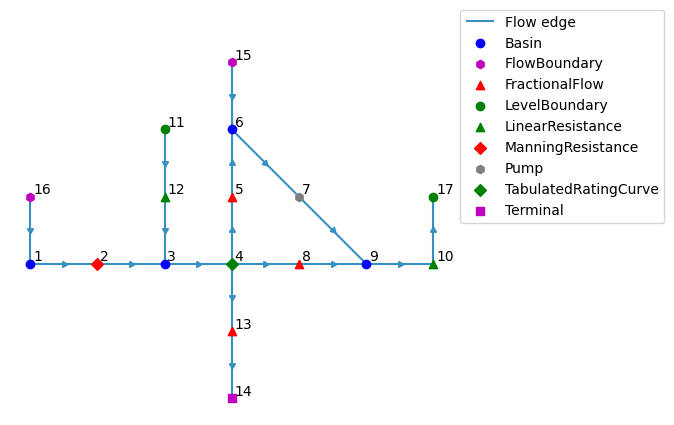

In [14]:
model.plot()